In [1]:
# Import libraries

import numpy as np # creating and manipulating arrays
import matplotlib.pyplot as plt # visualizing data
import sklearn # regression models
import statsmodels.api as sm 
import pandas as pd
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score  as acc
from mlxtend.feature_selection import SequentialFeatureSelector as sfs


In [2]:
# Import the data from the file and look out the descriptive data
worker = pd.read_csv("garments_worker_productivity.csv")
worker.describe()

,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
count,1197.000000,1197.000000,1197.000000,691.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000
mean,6.426901,0.729632,15.062172,1190.465991,4567.460317,38.210526,0.730159,0.369256,0.150376,34.609858,0.735091
std,3.463963,0.097891,10.943219,1837.455001,3348.823563,160.182643,12.709757,3.268987,0.427848,22.197687,0.174488
min,1.000000,0.070000,2.900000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.233705
25%,3.000000,0.700000,3.940000,774.500000,1440.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.650307
50%,6.000000,0.750000,15.260000,1039.000000,3960.000000,0.000000,0.000000,0.000000,0.000000,34.000000,0.773333
75%,9.000000,0.800000,24.260000,1252.500000,6960.000000,50.000000,0.000000,0.000000,0.000000,57.000000,0.850253
max,12.000000,0.800000,54.560000,23122.000000,25920.000000,3600.000000,300.000000,45.000000,2.000000,89.000000,1.120437


In [3]:
# Convert categorical varibale into quantative
worker['department'] = worker['department'].astype('category')
worker['department'] = worker['department'].cat.codes

worker['day'] = worker['day'].astype('category')
worker['day'] = worker['day'].cat.codes

worker['quarter'] = worker['quarter'].astype('category')
worker['quarter'] = worker['quarter'].cat.codes

In [4]:
worker.head()

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,1/1/2015,0,2,3,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
1,1/1/2015,0,1,3,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500
2,1/1/2015,0,2,3,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
3,1/1/2015,0,2,3,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
4,1/1/2015,0,2,3,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382


In [5]:
# replace NaN value by forward fill
work1= worker.fillna(method ='ffill', axis =1)
work1

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,1/1/2015,0,2,3,8,0.8,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
1,1/1/2015,0,1,3,1,0.75,3.94,3.94,960,0,0.0,0,0,8.0,0.8865
2,1/1/2015,0,2,3,11,0.8,11.41,968.0,3660,50,0.0,0,0,30.5,0.80057
3,1/1/2015,0,2,3,12,0.8,11.41,968.0,3660,50,0.0,0,0,30.5,0.80057
4,1/1/2015,0,2,3,6,0.8,25.9,1170.0,1920,50,0.0,0,0,56.0,0.800382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1192,3/11/2015,1,0,5,10,0.75,2.9,2.9,960,0,0.0,0,0,8.0,0.628333
1193,3/11/2015,1,0,5,8,0.7,3.9,3.9,960,0,0.0,0,0,8.0,0.625625
1194,3/11/2015,1,0,5,7,0.65,3.9,3.9,960,0,0.0,0,0,8.0,0.625625
1195,3/11/2015,1,0,5,9,0.75,2.9,2.9,1800,0,0.0,0,0,15.0,0.505889


In [6]:
#Removing the ouliners
# Max = 75% + 1.5*(75%-25%)
max_wip = 1252.5 + 1.5*(1254.5-774.5)
max_incen = 50.0 + 1.5*(50-0)
max_time =  6960 + 1.5*(6960-0)
new_work = work1[work1['wip'] <= max_wip]
new_work1 = new_work[new_work['incentive'] <= max_incen]
new_work2 = new_work1[new_work1['over_time'] <= max_time]
new_work2

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,1/1/2015,0,2,3,8,0.8,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
1,1/1/2015,0,1,3,1,0.75,3.94,3.94,960,0,0.0,0,0,8.0,0.8865
2,1/1/2015,0,2,3,11,0.8,11.41,968.0,3660,50,0.0,0,0,30.5,0.80057
3,1/1/2015,0,2,3,12,0.8,11.41,968.0,3660,50,0.0,0,0,30.5,0.80057
4,1/1/2015,0,2,3,6,0.8,25.9,1170.0,1920,50,0.0,0,0,56.0,0.800382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1192,3/11/2015,1,0,5,10,0.75,2.9,2.9,960,0,0.0,0,0,8.0,0.628333
1193,3/11/2015,1,0,5,8,0.7,3.9,3.9,960,0,0.0,0,0,8.0,0.625625
1194,3/11/2015,1,0,5,7,0.65,3.9,3.9,960,0,0.0,0,0,8.0,0.625625
1195,3/11/2015,1,0,5,9,0.75,2.9,2.9,1800,0,0.0,0,0,15.0,0.505889


In [7]:
# Create inputs and output

y = new_work2['actual_productivity']
y = y.astype(float)
x = new_work2.drop(columns=['actual_productivity', 'date'])
x = x.astype(float)

In [8]:
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                 
Dep. Variable:     actual_productivity   R-squared (uncentered):                   0.962
Model:                             OLS   Adj. R-squared (uncentered):              0.961
Method:                  Least Squares   F-statistic:                              2252.
Date:                 Thu, 15 Sep 2022   Prob (F-statistic):                        0.00
Time:                         15:46:48   Log-Likelihood:                          581.03
No. Observations:                 1173   AIC:                                     -1136.
Df Residuals:                     1160   BIC:                                     -1070.
Df Model:                           13                                                  
Covariance Type:             nonrobust                                                  
                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------

After iterating all the code, data showed that there are several variables such as deparment, day, over_time, idel_time, no_of_style_change are not significant. In addition the adjusted R-squares is .962 which indicats that if the independent variables change one unit, the actual productivity (dependent variable) would be changed 96.2%. Hence the non-significant variables will be dropped.

In [9]:
x = x.drop(columns =['department','day','over_time','idle_time','no_of_style_change'],axis=1)
x.to_csv('new_example', index =False)

In [37]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .2, random_state = 42)

In [38]:
#Q-3 : Compare the performance between OLS and SGD 

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

In [39]:
reg = make_pipeline(StandardScaler(), SGDRegressor(max_iter=1000, tol=1e-3))
reg.fit(x_train, y_train)
y_pred = reg.predict(x_test)
y_pred = pd.DataFrame(y_pred, columns = ['actual_productivity'])

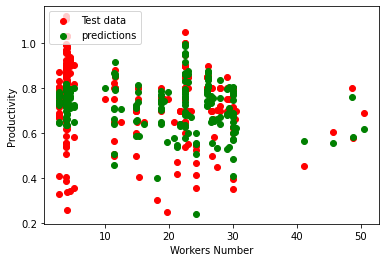

In [40]:
plt.scatter(x_test['smv'], y_test, color = "red", label = "Test data")
plt.scatter(x_test['smv'], y_pred, color = "green", label = "predictions")
plt.xlabel("Workers Number")
plt.ylabel("Productivity")
plt.legend(loc="upper left")
plt.show()

In [42]:
val_error = mean_squared_error(y_test, y_pred)

y_train_pred = reg.predict(x_train)
train_error = mean_squared_error(y_train, y_train_pred)

# Get validation scores
scores = cross_validate(reg, x_train, y_train, cv=3)

print("Training MSE: ", train_error)
print("Validation MSE: ", np.mean(scores['test_score']))

score = reg.score(x_test, y_test)
print("R-squared:", score)

Training MSE:  0.020169670170908854
Validation MSE:  0.3248108468336805
R-squared: 0.3980036702777472


Between OLS and SGD methods, the performance is better OLS than SGD because when R- squared would be considered as an evaluation requirement, OLS R-square is 0.962 whereas SGD's R-square is 0.398. If the independent variables changings impacts on dependent avriables significantly, we could predict our demands.

In [43]:
#Q-4 Develope a polynomial regression with stochastic gradient descent.
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size = .2, random_state = 42)

In [57]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

poly_features = PolynomialFeatures(degree=2, include_bias=False)
x_train_poly = poly_features.fit_transform(x_train)
x_test_poly = poly_features.fit_transform(x_test)
x_val_poly = poly_features.fit_transform(x_val)


sgd_reg = SGDRegressor(alpha=0.0001, max_iter=1000, tol=.001, random_state=42)
sgd_reg.fit(x_train_poly, y_train.ravel())
poly_train_pred = sgd_reg.predict(x_train_poly)
poly_test_pred = sgd_reg.predict(x_test_poly)
poly_val_pred = sgd_reg.predict(x_val_poly)

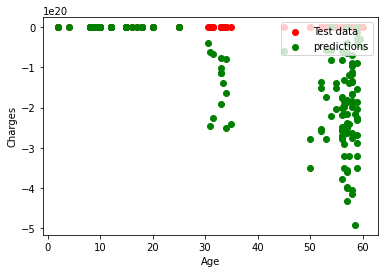

In [58]:
plt.scatter(x_test['no_of_workers'], y_test, color = "red", label = "Test data")
plt.scatter(x_test['no_of_workers'], poly_test_pred, color = "green", label = "predictions")
plt.xlabel("smv")
plt.ylabel("Productivity")
plt.legend(loc="upper right")
plt.show()

In [59]:
val_error = mean_squared_error(y_val, poly_val_pred)
train_error = mean_squared_error(y_train, poly_train_pred)

print("Training MSE: ", train_error)
print("Validation MSE: ", val_error)

score = sgd_reg.score(x_train_poly, y_train)
print("R-squared:", score)

Training MSE:  2.8792876708219034e+40
Validation MSE:  5.600530850955567e+40
R-squared: -9.348660958384404e+41


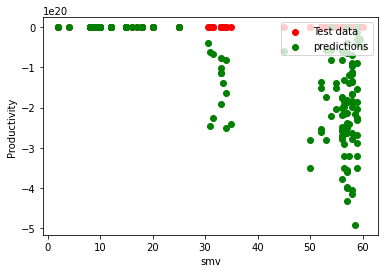

Training MSE:  2.879814870092491e+40
Validation MSE:  5.604349452444696e+40
R-squared: -9.350372703719258e+41


In [60]:
sgd_reg = SGDRegressor(alpha=0.001, max_iter=1000, tol=.001, random_state=42)
sgd_reg.fit(x_train_poly, y_train.ravel())
poly_train_pred = sgd_reg.predict(x_train_poly)
poly_test_pred = sgd_reg.predict(x_test_poly)
poly_val_pred = sgd_reg.predict(x_val_poly)

plt.scatter(x_test['no_of_workers'], y_test, color = "red", label = "Test data")
plt.scatter(x_test['no_of_workers'], poly_test_pred, color = "green", label = "predictions")
plt.xlabel("smv")
plt.ylabel("Productivity")
plt.legend(loc="upper right")
plt.show()

val_error = mean_squared_error(y_val, poly_val_pred)
train_error = mean_squared_error(y_train, poly_train_pred)

print("Training MSE: ", train_error)
print("Validation MSE: ", val_error)

score = sgd_reg.score(x_train_poly, y_train)
print("R-squared:", score)

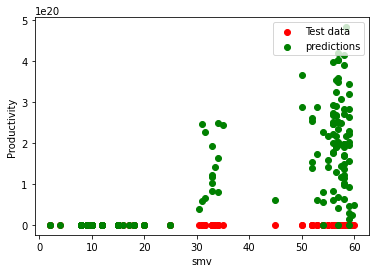

Training MSE:  2.8651664904841363e+40
Validation MSE:  5.61595366910525e+40
R-squared: -9.302811379459802e+41


In [66]:
sgd_reg = SGDRegressor(alpha=0.01, max_iter=1000, tol=.001, random_state=42)
sgd_reg.fit(x_train_poly, y_train.ravel())
poly_train_pred = sgd_reg.predict(x_train_poly)
poly_test_pred = sgd_reg.predict(x_test_poly)
poly_val_pred = sgd_reg.predict(x_val_poly)

plt.scatter(x_test['no_of_workers'], y_test, color = "red", label = "Test data")
plt.scatter(x_test['no_of_workers'], poly_test_pred, color = "green", label = "predictions")
plt.xlabel("smv")
plt.ylabel("Productivity")
plt.legend(loc="upper right")
plt.show()

val_error = mean_squared_error(y_val, poly_val_pred)
train_error = mean_squared_error(y_train, poly_train_pred)

print("Training MSE: ", train_error)
print("Validation MSE: ", val_error)

score = sgd_reg.score(x_train_poly, y_train)
print("R-squared:", score)

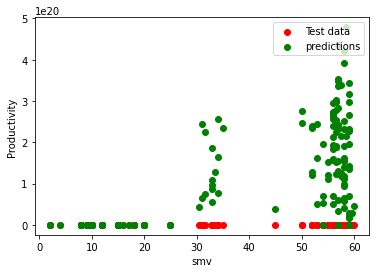

Training MSE:  2.60655861171064e+40
Validation MSE:  4.807152334686363e+40
R-squared: -8.46314627606627e+41


In [67]:
sgd_reg = SGDRegressor(alpha=0.1, max_iter=1000, tol=.001, random_state=42)
sgd_reg.fit(x_train_poly, y_train.ravel())
poly_train_pred = sgd_reg.predict(x_train_poly)
poly_test_pred = sgd_reg.predict(x_test_poly)
poly_val_pred = sgd_reg.predict(x_val_poly)

plt.scatter(x_test['no_of_workers'], y_test, color = "red", label = "Test data")
plt.scatter(x_test['no_of_workers'], poly_test_pred, color = "green", label = "predictions")
plt.xlabel("smv")
plt.ylabel("Productivity")
plt.legend(loc="upper right")
plt.show()

val_error = mean_squared_error(y_val, poly_val_pred)
train_error = mean_squared_error(y_train, poly_train_pred)

print("Training MSE: ", train_error)
print("Validation MSE: ", val_error)

score = sgd_reg.score(x_train_poly, y_train)
print("R-squared:", score)


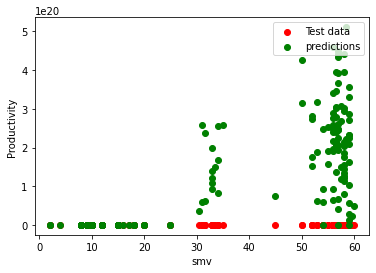

Training MSE:  3.255486618707852e+40
Validation MSE:  6.661805613627277e+40
R-squared: -1.0570128494374906e+42


In [68]:
sgd_reg = SGDRegressor(alpha=1, max_iter=1000, tol=.001, random_state=42)
sgd_reg.fit(x_train_poly, y_train.ravel())
poly_train_pred = sgd_reg.predict(x_train_poly)
poly_test_pred = sgd_reg.predict(x_test_poly)
poly_val_pred = sgd_reg.predict(x_val_poly)

plt.scatter(x_test['no_of_workers'], y_test, color = "red", label = "Test data")
plt.scatter(x_test['no_of_workers'], poly_test_pred, color = "green", label = "predictions")
plt.xlabel("smv")
plt.ylabel("Productivity")
plt.legend(loc="upper right")
plt.show()

val_error = mean_squared_error(y_val, poly_val_pred)
train_error = mean_squared_error(y_train, poly_train_pred)

print("Training MSE: ", train_error)
print("Validation MSE: ", val_error)

score = sgd_reg.score(x_train_poly, y_train)
print("R-squared:", score)

For stochastic regression descent, learning rate = 1 is the best among all learning rate because of r-quared which is -1.05.

In [69]:
#Q-5 Lasso Model Development.
lasso = make_pipeline(StandardScaler(), SGDRegressor(alpha=0.01, epsilon=0.01, eta0=0.1, penalty="l1", max_iter=1000, tol=1e-3, random_state=42))
lasso.fit(x_train, y_train)
lasso_train_pred = lasso.predict(x_train)
lasso_test_pred = lasso.predict(x_test)
lasso_val_pred = lasso.predict(x_val)

val_error = mean_squared_error(y_val, lasso_val_pred)
train_error = mean_squared_error(y_train, lasso_train_pred)

# Get validation scores
scores = cross_validate(lasso, x_train, y_train, cv=3)

print("Training MSE: ", train_error)
print("Validation MSE: ", np.mean(scores['test_score']))

score = lasso.score(x_test, y_test)
print("R-squared:", score)

Training MSE:  0.021800902135601985
Validation MSE:  0.23960814377150805
R-squared: 0.27517059121596077


In [73]:
lasso = make_pipeline(StandardScaler(), SGDRegressor(early_stopping = True, penalty="l1", max_iter=1000, tol=1e-3, random_state=42))
lasso.fit(x_train, y_train)
lasso_train_pred = lasso.predict(x_train)
lasso_test_pred = lasso.predict(x_test)
lasso_val_pred = lasso.predict(x_val)

val_error = mean_squared_error(y_val, lasso_val_pred)
train_error = mean_squared_error(y_train, lasso_train_pred)

# Get validation scores
scores = cross_validate(lasso, x_train, y_train, cv=3)

print("Training MSE: ", train_error)
print("Validation MSE: ", np.mean(scores['test_score']))

score = lasso.score(x_test, y_test)
print("R-squared:", score)

Training MSE:  0.02013844414506545
Validation MSE:  0.32421238924828705
R-squared: 0.34721276247265254


After using Early stopping method, R-squared has been improved to 34.72%.

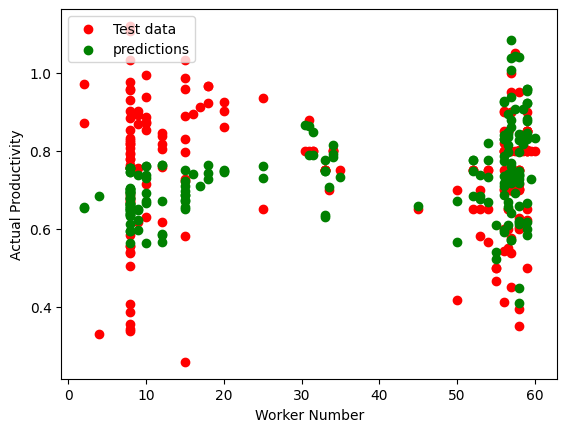

In [20]:
#Q-6: Ridge model development.

ridge = make_pipeline(StandardScaler(), SGDRegressor(alpha=0.0001, epsilon=0.01, eta0=0.1, penalty="l2", max_iter=1000, tol=1e-3, random_state=42))
ridge.fit(x_train, y_train)
y_pred = ridge.predict(x_test)

plt.scatter(x_test['no_of_workers'], y_test, color = "red", label = "Test data")
plt.scatter(x_test['no_of_workers'], y_pred, color = "green", label = "predictions")
plt.xlabel("Worker Number")
plt.ylabel("Actual Productivity")
plt.legend(loc="upper left")
plt.show()

In [21]:
ridge_train_pred = ridge.predict(x_train)
ridge_test_pred = ridge.predict(x_test)
ridge_val_pred = ridge.predict(x_val)

val_error = mean_squared_error(y_val, ridge_val_pred)
train_error = mean_squared_error(y_train, ridge_train_pred)

# Get validation scores
scores = cross_validate(ridge, x_train, y_train, cv=3)

print("Training MSE: ", train_error)
print("Validation MSE: ", np.mean(scores['test_score']))

score = ridge.score(x_test, y_test)
print("R-squared:", score)

Training MSE:  0.02350265987666992
Validation MSE:  0.20154462653588767
R-squared: 0.19760271349539793


In [22]:
#Q-7: Implement Elasticnet Regression Model.

elasticnet = make_pipeline(StandardScaler(), SGDRegressor(alpha=0.0001, epsilon=0.01, eta0=0.1, penalty="elasticnet", max_iter=1000, tol=1e-3, random_state=42))
elasticnet.fit(x_train, y_train)
elasticnet_train_pred = elasticnet.predict(x_train)
elasticnet_test_pred = elasticnet.predict(x_test)
elasticnet_val_pred = elasticnet.predict(x_val)

val_error = mean_squared_error(y_val, elasticnet_val_pred)
train_error = mean_squared_error(y_train, elasticnet_train_pred)

# Get validation scores
scores = cross_validate(elasticnet, x_train, y_train, cv=3)

print("Training MSE: ", train_error)
print("Validation MSE: ", np.mean(scores['test_score']))

score = elasticnet.score(x_test, y_test)
print("R-squared:", score)

Training MSE:  0.023528126044198638
Validation MSE:  0.2054244851764674
R-squared: 0.19607363487930285


Answer to the Q-8:
Among linear, lasso, ridge and elasticnet regression model, linear model has the best r-squared. The r-squared is considered because there are no p-value of other models. 